### Denali Analysis Plots

In [54]:
import os, pdb
from glob import glob
import numpy as np
import fitsio
from astropy.table import Table

In [55]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns

sns.set(context='talk', style='ticks', palette='deep', font_scale=1.3)#, rc=rc)
colors = sns.color_palette()

pref = {'ELG': {'color': colors[0], 'marker': 's'},
        'LRG': {'color': colors[3], 'marker': '^'},
        'QSO': {'color': colors[4], 'marker': 'x'},
        'BGS_ANY': {'color': colors[8], 'marker': 'o'}
       }

%matplotlib inline

In [56]:
specprod = 'denali'
reduxdir = os.path.join(os.getenv('DESI_ROOT'), 'spectro', 'redux', specprod)
fastspecdir = os.path.join(os.getenv('DESI_ROOT'), 'spectro', 'fastspecfit', specprod, 'tiles')
figdir = os.path.join(os.getenv('DESI_ROOT'), 'users', 'ioannis', 'talks', '2021', '21apr-denali')
#figdir = os.path.join(os.getenv('HOME'), 'research', 'talks', '2021', '21Apr-denali')
print(fastspecdir)
print(figdir)

/global/cfs/cdirs/desi/spectro/fastspecfit/denali/tiles
/global/cfs/cdirs/desi/users/ioannis/talks/2021/21apr-denali


### Read the tiles file and the fastspecfit results

In [57]:
def read_tileinfo():
    tileinfo = Table.read(os.path.join(reduxdir, 'tiles-denali.csv'))
    tileinfo = tileinfo[tileinfo['SURVEY'] != 'unknown']
    tileinfo = tileinfo[np.argsort(tileinfo['TILEID'])]
    return tileinfo

tileinfo = read_tileinfo()
print(len(tileinfo), tileinfo.colnames)
#tileinfo

173 ['TILEID', 'SURVEY', 'FAPRGRM', 'FAFLAVOR', 'NEXP', 'EXPTIME', 'EFFTIME_ETC', 'EFFTIME_SPEC', 'EFFTIME_GFA', 'GOALTIME', 'OBSSTATUS', 'ZDONE', 'ELG_EFFTIME_DARK', 'BGS_EFFTIME_BRIGHT', 'LYA_EFFTIME_DARK', 'GOALTYPE', 'MINTFRAC', 'LASTNIGHT']


In [58]:
#specfile = os.path.join(fastspecdir, 'merged', 'fastspec-{}-cumulative.fits'.format(specprod))
#meta = Table(fitsio.read(specfile, 'METADATA'))

In [59]:
def read_fastspecfit(tileinfo):
    
    from desitarget.targets import main_cmx_or_sv

    specfile = os.path.join(fastspecdir, 'merged', 'fastspec-{}-cumulative.fits'.format(specprod))
    photfile = os.path.join(fastspecdir, 'merged', 'fastphot-{}-cumulative.fits'.format(specprod))

    spec = Table(fitsio.read(specfile, 'FASTSPEC'))
    meta = Table(fitsio.read(specfile, 'METADATA'))
    phot = Table(fitsio.read(photfile, 'FASTPHOT'))

    assert(np.all(spec['TARGETID'] == phot['TARGETID']))
    
    print('Read {} objects from {}'.format(len(spec), specfile))
    print('Read {} objects from {}'.format(len(phot), photfile))
    ngal = len(spec)
    
    # convenience magnitudes and targeting variables
    for band in ('G', 'R', 'Z', 'W1'):
        phot['{}MAG'.format(band)] = np.zeros(ngal, 'f4')
        good = np.where(meta['FLUX_{}'.format(band)] > 0)[0]
        phot['{}MAG'.format(band)][good] = 22.5 - 2.5 * np.log10(meta['FLUX_{}'.format(band)][good])
        
    for band in ('G', 'R', 'Z'):
        phot['{}FIBERMAG'.format(band)] = np.zeros(ngal, 'f4')
        good = np.where(meta['FIBERFLUX_{}'.format(band)] > 0)[0]
        phot['{}FIBERMAG'.format(band)][good] = 22.5 - 2.5 * np.log10(meta['FIBERFLUX_{}'.format(band)][good])

    for targ in ['BGS_ANY', 'ELG', 'LRG', 'QSO']:
        spec[targ] = np.zeros(ngal, bool)
        phot[targ] = np.zeros(ngal, bool)
        
    for tile in tileinfo['TILEID']:
        I = np.where(meta['TILEID'] == tile)[0]
        if len(I) == 0:
            continue

        (desicol, bgscol, mwscol), (desimask, bgsmask, mwsmask), survey = main_cmx_or_sv(meta[I])
        #print(tile, survey)
        
        for targ in ['BGS_ANY', 'ELG', 'LRG', 'QSO']:
            phot[targ][I] = meta[desicol][I] & desimask.mask(targ) != 0
            spec[targ][I] = meta[desicol][I] & desimask.mask(targ) != 0
            
    print()
    for targ in ['BGS_ANY', 'ELG', 'LRG', 'QSO']:
        print('  {}: {}'.format(targ, np.sum(phot[targ])))
    
    return phot, spec, meta

allphot, allspec, allmeta = read_fastspecfit(tileinfo)
#spec

Read 414109 objects from /global/cfs/cdirs/desi/spectro/fastspecfit/denali/tiles/merged/fastspec-denali-cumulative.fits
Read 414109 objects from /global/cfs/cdirs/desi/spectro/fastspecfit/denali/tiles/merged/fastphot-denali-cumulative.fits

  BGS_ANY: 136528
  ELG: 120470
  LRG: 66355
  QSO: 79030


### BGS Analysis

Writing /global/cfs/cdirs/desi/users/ioannis/talks/2021/21apr-denali/zhist.png


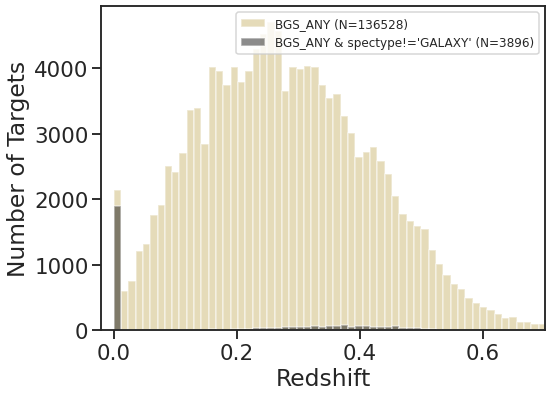

In [60]:
def zhist(png=None):
    targ = 'BGS_ANY'
    itarg = np.where(allspec[targ])[0]
    itarg_nongal = np.where(allspec[targ] * (allmeta['SPECTYPE'] != 'GALAXY'))[0]
    #itarg_dchi2 = np.where(allspec[targ] * (allmeta['DELTACHI2'] < 40))[0]
    
    zlim = (-0.02, 0.7)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    _ = ax.hist(allmeta['Z'][itarg], label='{} (N={})'.format(targ, len(itarg)), 
                bins=500, alpha=0.5, color=pref[targ]['color'])
    #_ = ax.hist(allmeta['Z'][itarg_dchi2], label=r'{} & $\Delta\chi^2>40$ (N={})'.format(
    #    targ, len(itarg_dchi2)), range=zlim, bins=75, alpha=0.5, color='k')
    _ = ax.hist(allmeta['Z'][itarg_nongal], label=r"{} & spectype!='GALAXY' (N={})".format(
        targ, len(itarg_nongal)), bins=500, alpha=0.5, color='k')
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
    #ax.yaxis.set_major_locator(ticker.MultipleLocator(500))
    
    ax.set_xlim(zlim)
    ax.set_xlabel('Redshift')
    ax.set_ylabel('Number of Targets')
    ax.legend(fontsize=12)#, loc='upper right')
    
    fig.subplots_adjust(left=0.18, bottom=0.2, top=0.95, right=0.95)
    
    if png:
        print('Writing {}'.format(png))
        fig.savefig(png)
        
zhist(png=os.path.join(figdir, 'zhist.png'))

Writing /global/cfs/cdirs/desi/users/ioannis/talks/2021/21apr-denali/bgs-tiledepth.png


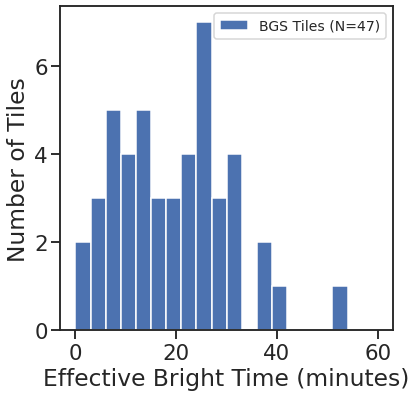

In [61]:
def qa_tiledepth(tileinfo, png=None):
    target, efftimecol = 'bgs', 'BGS_EFFTIME_BRIGHT'

    thesetiles = tileinfo[[target in faprogram for faprogram in tileinfo['FAPRGRM']]]
    deep = np.where(thesetiles[efftimecol] > np.percentile(thesetiles[efftimecol], 75))[0]
    
    xlim = (0, 60)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    
    _ = ax.hist(thesetiles[efftimecol]/60, range=xlim, 
                bins=20, label='BGS Tiles (N={})'.format(
        len(thesetiles)))
    #_ = ax.hist(thesetiles[efftimecol][deep]/60, range=xlim,
    #            bins=20, label='Deepest 25%', alpha=0.8)
    
    #ax.set_xlabel('{} (sec)'.format(efftimecol))
    ax.set_xlabel('Effective Bright Time (minutes)')
    ax.set_ylabel('Number of Tiles')
    ax.legend(fontsize=14)
    
    deep = deep[np.argsort(thesetiles[efftimecol][deep])][::-1]
    deeptiles = thesetiles[deep]
    
    fig.subplots_adjust(left=0.18, bottom=0.2, top=0.95, right=0.95)
    
    if png:
        print('Writing {}'.format(png))
        fig.savefig(png)
        
    return thesetiles
        
bgstiles = qa_tiledepth(tileinfo, png=os.path.join(figdir, 'bgs-tiledepth.png'))    

### Broadband photometry

Writing /global/cfs/cdirs/desi/users/ioannis/talks/2021/21apr-denali/bgs-restphot.png


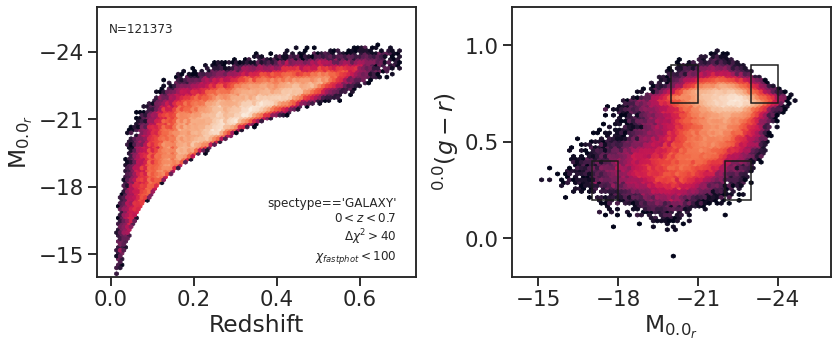

In [62]:
def restphot(png=None):
    
    targ = 'BGS_ANY'
    itarg = np.where(allspec[targ] * (allmeta['DELTACHI2'] > 40) * 
                     (allmeta['SPECTYPE'] == 'GALAXY') *
                     (allmeta['Z'] < 0.7) * 
                     (allphot['CONTINUUM_CHI2'] < 1e2))[0]
    
    spec = allspec[itarg]
    phot = allphot[itarg]
    meta = allmeta[itarg]

    zlim = (0, 0.7)
    absmaglim = (-14, -26)
    grlim = (-0.2, 1.2)
    ss = 10
    label = 'All BGS'
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    #ax1.scatter(meta['Z'], phot['ABSMAG_R'], s=ss, 
    #            color=pref[targ]['color'], marker=pref[targ]['marker'],
    #            alpha=0.7, label=label)
    im = ax1.hexbin(meta['Z'], phot['ABSMAG_R'],
                    mincnt=5, gridsize=80, bins='log',
                    extent=np.hstack((zlim, absmaglim)))

    #ax.set_xlim(0.01, 200)
    ax1.set_ylim(absmaglim)
    ax1.set_xlabel('Redshift')
    ax1.set_ylabel(r'M$_{0.0_{r}}$')
    #ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(3))
    
    #ax2.scatter(phot['ABSMAG_R'], phot['ABSMAG_G']-phot['ABSMAG_R'],
    #            s=ss, color=pref[targ]['color'], marker=pref[targ]['marker'],
    #            alpha=0.7)
    im = ax2.hexbin(phot['ABSMAG_R'], phot['ABSMAG_G']-phot['ABSMAG_R'],
                    mincnt=5, gridsize=80, bins='log',
                    extent=np.hstack((absmaglim, grlim)))
    
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(3))
    ax2.set_xlim(absmaglim)
    ax2.set_ylim(grlim)
    ax2.set_ylabel(r'$^{0.0}(g - r)$')
    ax2.set_xlabel(r'M$_{0.0_{r}}$')
    
    txt = '\n'.join((
        #'N={}'.format(len(itarg)),
        "spectype=='GALAXY'",
        r'$0<z<0.7$',
        r'$\Delta\chi^2>40$',
        r'$\chi_{{fastphot}}<100$'))
    ax1.text(0.94, 0.04, txt, ha='right', va='bottom',
            transform=ax1.transAxes, fontsize=12)
    ax1.text(0.04, 0.94, 'N={}'.format(len(itarg)), ha='left', va='top',
            transform=ax1.transAxes, fontsize=12)
    #ax1.legend(loc='lower right', markerscale=3, fontsize=16)    
    
    from matplotlib.patches import Rectangle
    ax2.add_patch(Rectangle((-24, 0.7), 1, 0.2, # red, bright
                  facecolor='none', edgecolor='k'))
    ax2.add_patch(Rectangle((-21, 0.7), 1, 0.2, # red, faint
                  facecolor='none', edgecolor='k'))
    ax2.add_patch(Rectangle((-23, 0.2), 1, 0.2, # blue, bright
                  facecolor='none', edgecolor='k'))
    ax2.add_patch(Rectangle((-18, 0.2), 1, 0.2, # blue, faint
                  facecolor='none', edgecolor='k'))
        
    fig.subplots_adjust(wspace=0.3, bottom=0.2, left=0.1, right=0.95, top=0.95)
    
    if png:
        print('Writing {}'.format(png))
        fig.savefig(png)
        
restphot(png=os.path.join(figdir, 'bgs-restphot.png'))

### 4000-A break & line-emission

72686 112761 0.6446023004407552
Writing /global/cfs/cdirs/desi/users/ioannis/talks/2021/21apr-denali/ewha-vs-d4000.png


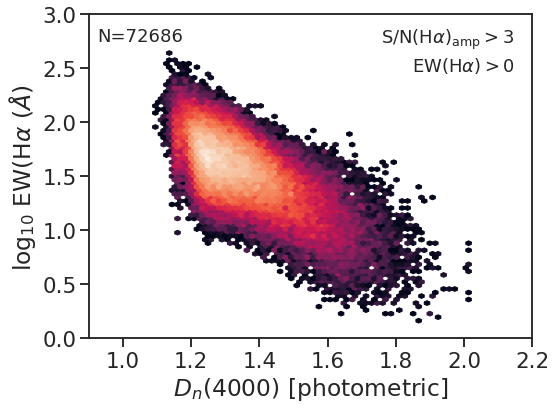

In [63]:
def ewha_vs_d4000(png=None):

    targ = 'BGS_ANY'
    itarg = np.where(allspec[targ] * (allmeta['DELTACHI2'] > 40) * 
                     (allmeta['SPECTYPE'] == 'GALAXY') *
                     (allmeta['Z'] < 0.7) *                      
                     (allphot['CONTINUUM_CHI2'] < 1e2) *
                     (allspec['HALPHA_AMP'] * np.sqrt(allspec['HALPHA_AMP_IVAR']) > 3) * 
                     (allspec['HALPHA_EW'] > 0))[0]
    ewha = np.log10(allspec['HALPHA_EW'][itarg])
    d4000 = allphot['D4000_MODEL'][itarg]
    
    itarg2 = np.where(allspec[targ] * (allmeta['DELTACHI2'] > 40) * 
                     (allmeta['SPECTYPE'] == 'GALAXY') *
                     (allmeta['Z'] < 9800/6570-1) * 
                     (allphot['CONTINUUM_CHI2'] < 1e2))[0]
    print(len(itarg), len(itarg2), len(itarg)/len(itarg2))

    d4000lim = (0.9, 2.2)
    ewhalim = (0, 3.0)
    
    fig, ax1 = plt.subplots(figsize=(8, 6))
    im = ax1.hexbin(d4000, ewha,
                    mincnt=5, gridsize=80, bins='log',
                    extent=np.hstack((d4000lim, ewhalim)))

    ax1.set_xlim(d4000lim)
    ax1.set_ylim(ewhalim)
    ax1.set_xlabel(r'$D_{n}(4000)$ [photometric]')
    ax1.set_ylabel(r'$\log_{10}\ \mathrm{EW}(\mathrm{H}\alpha\ (\AA)$')
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    
    txt = '\n'.join((
        #'N={}'.format(len(itarg)),
        r'S/N(H$\alpha)_{\mathrm{amp}}>3$',
        r'EW(H$\alpha)>0$'))
    ax1.text(0.96, 0.96, txt, ha='right', va='top',
            transform=ax1.transAxes, fontsize=18)
    ax1.text(0.02, 0.96, 'N={}'.format(len(itarg)), ha='left', va='top',
            transform=ax1.transAxes, fontsize=18)
    
    fig.subplots_adjust(left=0.18, bottom=0.2, top=0.95, right=0.95)
    
    if png:
        print('Writing {}'.format(png))
        fig.savefig(png)
        
ewha_vs_d4000(png=os.path.join(figdir, 'ewha-vs-d4000.png'))

### Build fun stacked spectra!

In [101]:
def quick_coadd(flux3d, ivar3d):
    ivar = np.sum(ivar3d, axis=0)
    flux = np.zeros_like(ivar)
    good = np.where(ivar > 0)[0]
    flux[good] = np.sum(ivar3d[:, good] * flux3d[:, good], axis=0) / ivar[good]
    return flux, ivar

In [117]:
#stackfiles = np.array(glob(os.path.join(fastspecdir, 'stacks', 'bgs-*.fits')))
def build_stacks(alltiles, targ='BGS_ANY'):
    from desitarget.targets import main_cmx_or_sv
    
    def sample_cuts(sample_number, allmeta, allspec, allphot):
        
        (desicol, bgscol, mwscol), (desimask, bgsmask, mwsmask), survey = main_cmx_or_sv(allmeta)
        
        itarg = ( (allmeta[desicol] & desimask.mask(targ) != 0) * 
                  (allmeta['DELTACHI2'] > 40) * 
                  (allmeta['SPECTYPE'] == 'GALAXY') *
                  (allmeta['Z'] > 0.2) * (allmeta['Z'] < 0.4) * 
                  (allspec['CONTINUUM_CHI2'] < 20) * 
                  (allphot['CONTINUUM_CHI2'] < 1e2)
                )
        if sample_number == 0:
            I = np.where(
                itarg * 
                (allphot['D4000_MODEL'] > 1.8) * (allphot['D4000_MODEL'] < 2.0) * # red
                (allspec['HALPHA_AMP'] * np.sqrt(allspec['HALPHA_AMP_IVAR']) < 5) *
                (allspec['HALPHA_EW'] < 5))[0] # dead
        elif sample_number == 1:
            I = np.where(
                itarg * 
                (allphot['D4000_MODEL'] > 1.7) * (allphot['D4000_MODEL'] < 2.0) * # red
                (allspec['HALPHA_AMP'] * np.sqrt(allspec['HALPHA_AMP_IVAR']) > 5) * 
                (allspec['HALPHA_EW'] > 5))[0] # active
        elif sample_number == 2:
            I = np.where(
                itarg * 
                (allphot['D4000_MODEL'] > 1.1) * (allphot['D4000_MODEL'] < 1.2) * # blue
                (allspec['HALPHA_AMP'] * np.sqrt(allspec['HALPHA_AMP_IVAR']) > 5) * 
                (allspec['HALPHA_EW'] > 10))[0] # active
        else:
            pass
        
        return I

    nsample = 3 
    samples = [{'wave': [], 'flux': [], 'ivar': []} for x in np.arange(nsample)]
    
    for thistile in alltiles:
        stackfile = os.path.join(fastspecdir, 'stacks', 'bgs-{}-restflux.fits'.format(thistile['TILEID']))

        #print('Reading {}'.format(stackfile))
        flux = fitsio.read(stackfile, ext='FLUX')
        ivar = fitsio.read(stackfile, ext='IVAR')
        wave = fitsio.read(stackfile, ext='WAVE')
        allphot = Table(fitsio.read(stackfile, ext='FASTPHOT'))
        allspec = Table(fitsio.read(stackfile, ext='FASTSPEC'))
        allmeta = Table(fitsio.read(stackfile, ext='METADATA'))
        
        # select the sample of interest
        for sample_number in np.arange(len(samples)):
            I = sample_cuts(sample_number, allmeta, allspec, allphot)
            print(stackfile, sample_number, len(I))
            
            if len(I) > 0:
                phot = allphot[I]
                spec = allspec[I]
                meta = allmeta[I]
            
                if len(samples[sample_number]['wave']) == 0: # just need one
                    samples[sample_number]['wave'] = wave
                samples[sample_number]['flux'].append(flux[I, :])
                samples[sample_number]['ivar'].append(ivar[I, :])

    # now stack the arrays, for convenience
    for sample_number in np.arange(len(samples)):
        samples[sample_number]['flux'] = np.vstack(samples[sample_number]['flux'])
        samples[sample_number]['ivar'] = np.vstack(samples[sample_number]['ivar'])
    
    return samples
            
samples = build_stacks(bgstiles)

/global/cfs/cdirs/desi/spectro/fastspecfit/denali/tiles/stacks/bgs-80611-restflux.fits 0 218
/global/cfs/cdirs/desi/spectro/fastspecfit/denali/tiles/stacks/bgs-80611-restflux.fits 1 14
/global/cfs/cdirs/desi/spectro/fastspecfit/denali/tiles/stacks/bgs-80611-restflux.fits 2 31
/global/cfs/cdirs/desi/spectro/fastspecfit/denali/tiles/stacks/bgs-80612-restflux.fits 0 233
/global/cfs/cdirs/desi/spectro/fastspecfit/denali/tiles/stacks/bgs-80612-restflux.fits 1 27
/global/cfs/cdirs/desi/spectro/fastspecfit/denali/tiles/stacks/bgs-80612-restflux.fits 2 43
/global/cfs/cdirs/desi/spectro/fastspecfit/denali/tiles/stacks/bgs-80613-restflux.fits 0 173
/global/cfs/cdirs/desi/spectro/fastspecfit/denali/tiles/stacks/bgs-80613-restflux.fits 1 25
/global/cfs/cdirs/desi/spectro/fastspecfit/denali/tiles/stacks/bgs-80613-restflux.fits 2 35
/global/cfs/cdirs/desi/spectro/fastspecfit/denali/tiles/stacks/bgs-80614-restflux.fits 0 168
/global/cfs/cdirs/desi/spectro/fastspecfit/denali/tiles/stacks/bgs-80614-res

In [124]:
for sample in samples:
    print(sample['flux'].shape)

(8965, 22966)
(754, 22966)
(1714, 22966)


In [144]:
wave = samples[0]['wave']
flux_red, ivar_red = quick_coadd(samples[0]['flux'], samples[0]['ivar'])
flux_blue, ivar_blue = quick_coadd(samples[2]['flux'], samples[2]['ivar'])

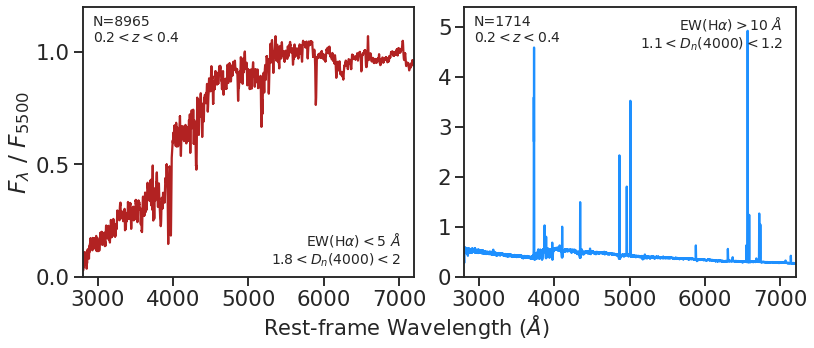

In [227]:
xlim = (2800, 7200)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(wave, flux_red / np.interp(5500, wave, flux_red), color='firebrick')
ax[1].plot(wave, flux_blue / np.interp(5500, wave, flux_red), color='dodgerblue')

ax[0].set_ylim(0, 1.2)
ax[1].set_ylim(0, 5.4)
ax[0].yaxis.set_major_locator(ticker.MultipleLocator(0.5))

for xx in ax:
    xx.set_xlim(xlim)
    #xx.set_yticklabels([])
    #xx.set_xlabel('Rest-frame Wavelength ($\AA$)')
    xx.xaxis.set_major_locator(ticker.MultipleLocator(1000))
    

#ax[0].set_ylabel(r'$F_{\lambda}$ (normalized)')
ax[0].set_ylabel(r'$F_{\lambda}\ /\ F_{5500}$')

txt = '\n'.join((
    r'EW(H$\alpha)<5\ \AA$',
    r'$1.8<D_{n}(4000)<2$'))
ax[0].text(0.96, 0.03, txt, ha='right', va='bottom',
           transform=ax[0].transAxes, fontsize=14)

txt = '\n'.join((
    r'EW(H$\alpha)>10\ \AA$',
    r'$1.1<D_{n}(4000)<1.2$'))
ax[1].text(0.96, 0.97, txt, ha='right', va='top',
           transform=ax[1].transAxes, fontsize=14)

txt = '\n'.join(('N=8965', r'$0.2 < z < 0.4$'))
ax[0].text(0.03, 0.97, txt, ha='left', va='top',
           transform=ax[0].transAxes, fontsize=14)

txt = '\n'.join(('N=1714', r'$0.2 < z < 0.4$'))
ax[1].text(0.03, 0.97, txt, ha='left', va='top',
           transform=ax[1].transAxes, fontsize=14)

fig.text(0.5, 0.1, r'Rest-frame Wavelength ($\AA$)',
         ha='center', va='top', fontsize=21)
    
fig.subplots_adjust(wspace=0.15, bottom=0.2, right=0.95, top=0.95)

fig.savefig(os.path.join(figdir, 'bgs-stacked-red-blue.png'))

In [127]:
sample = samples[1]
flux, ivar = quick_coadd(sample['flux'], sample['ivar'])

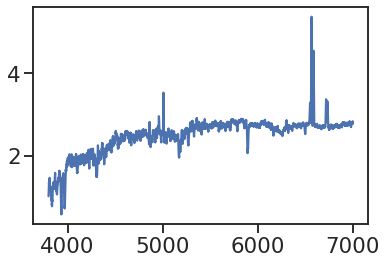

In [129]:
xlim = (3800, 7000)
wave = sample['wave']
I = (wave > xlim[0]) * (wave < xlim[1])
plt.plot(wave[I], flux[I])

In [130]:
sample = samples[2]
flux, ivar = quick_coadd(sample['flux'], sample['ivar'])

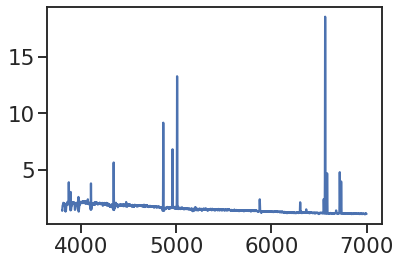

In [131]:
xlim = (3800, 7000)
wave = sample['wave']
I = (wave > xlim[0]) * (wave < xlim[1])
plt.plot(wave[I], flux[I])

In [ ]:
stop

#### Select mildly deep BGS tiles

2877 9599
[80641 80642 80643 80644 80645 80646 80647 80648 80649 80650 80651 80652
 80653 80654 80655 80656 80657 80658 80659 80660 80661 80662 80663 80664
 80665 80666 80611 80612 80613 80614 80742 80616 80617 80618 80619 80740
 80741 80624 80627 80629 80632 80633 80635 80638]
[80613]


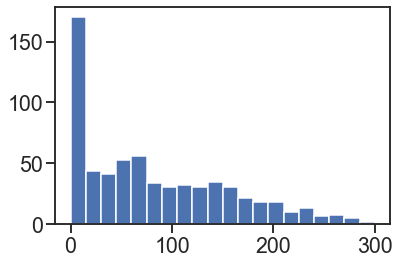

In [20]:
expbgs_all = expinfo['TARGETS'] == 'BGS+MWS'
expbgs_deep = (expinfo['TARGETS'] == 'BGS+MWS') * (expinfo['EFFTIME_BRIGHT'] > 120)
_ = plt.hist(expinfo['EFFTIME_BRIGHT'][expbgs_all], bins=20, range=(0, 300))
expbgs = expinfo[expbgs_deep]
thesetiles = np.array(list(set(expbgs['TILEID'])))

I = np.isin(allphot['TILEID'], thesetiles)
phot = allphot[I]
spec = allspec[I]
print(len(spec), len(allspec))
print(thesetiles)
print(np.array(list(set(spec['TILEID']))))

2443


Text(0, 0.5, '$(z - w1) - 3 (g - r) / 2.5 + 1.2$')

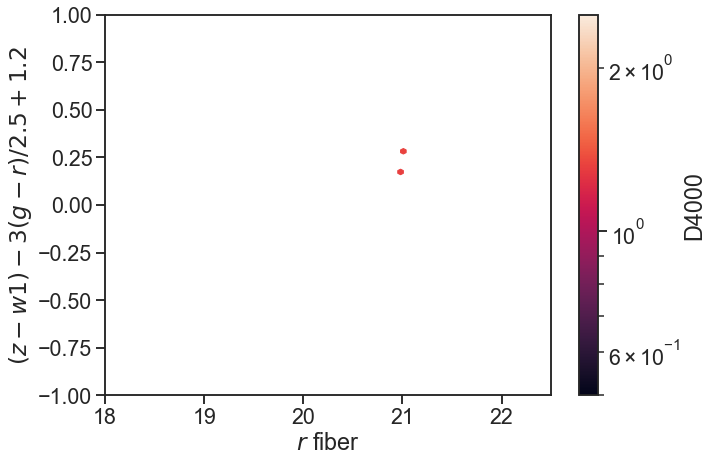

In [21]:
xlim = (18, 22.5)
ylim = (-1, 1)
I = np.where(
    (spec['ZWARN'] == 0) * (spec['SPECTYPE'] != 'STAR') * 
    #(spec['CONTINUUM_SNR'][:, 1] > 5) * 
    (phot['FLUX_G'] > 0) * (phot['FLUX_R'] > 0) * (phot['FLUX_Z'] > 0) * 
    (phot['FLUX_W1'] > 0) * (phot['FIBERTOTFLUX_R'] > 0) *              
    (phot['D4000_MODEL'] > 0.5) * (phot['D4000_MODEL'] < 2.5)
)[0]
print(len(I))
schlegel_color = (phot['ZMAG'][I] - phot['W1MAG'][I]) - 3/2.5 * (phot['GMAG'][I] - phot['RMAG'][I]) + 1.2

fig, ax = plt.subplots(figsize=(10, 7))
im = ax.hexbin(phot['RFIBERMAG'][I], schlegel_color, mincnt=5,
               gridsize=80, vmin=0.5, vmax=2.5, bins='log',
               extent=np.hstack((xlim, ylim)), C=phot['D4000_MODEL'][I], reduce_C_function=np.mean)
#cax = fig.add_axes([0.9, 0.15, 0.025, 0.7])
cb = fig.colorbar(im, label='D4000')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel(r'$r$ fiber')
ax.set_ylabel(r'$(z - w1) - 3 (g - r) / 2.5 + 1.2$')

<ipython-input-59-31bde38fa987>:26: RuntimeWarning: invalid value encountered in multiply
  ((allspec['MGII_2800_AMP'] * allspec['MGII_2800_AMP_IVAR']) > 3.0)))[0]
/Users/ioannis/anaconda3/envs/desi/lib/python3.8/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
<ipython-input-59-31bde38fa987>:28: RuntimeWarning: invalid value encountered in multiply
  ((allspec['MGII_2800_AMP'] * allspec['MGII_2800_AMP_IVAR']) <= 3.0)))[0]
/Users/ioannis/anaconda3/envs/desi/lib/python3.8/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less_equal
  result = getattr(super(), op)(other)
<ipython-input-59-31bde38fa987>:35: RuntimeWarning: invalid value encountered in multiply
  ((allspec['MGII_2800_AMP'] * allspec['MGII_2800_AMP_IVAR']) > 3.0))[0]
<ipython-input-59-31bde38fa987>:38: RuntimeWarning: invalid value encountered in multiply
  ((allspec['MGII_2800_AMP'] * allspec['MGII_

Number of QSOs: 1451
Writing /Users/ioannis/research/talks/2021/21Mar25-cascades/frac-qso-mgii.png


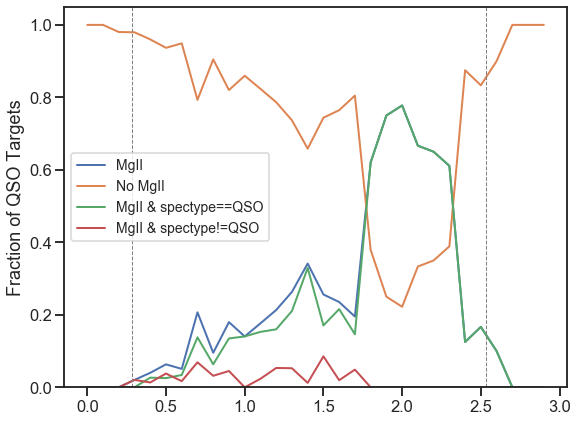

In [59]:
def zhist_bins(deltaz=0.1, zmin=0.0, zmax=2, target='QSO', binedges=False):
    if target.strip() == 'LRG':
        zmin, zmax = 0.0, 1.2
    elif target.strip() == 'BGS':
        zmin, zmax = 0.0, 0.5
    elif target.strip() == 'QSO':
        zmin, zmax = 0.0, 3.0
    else:
        pass
    if binedges:
        bins = np.arange(zmin, zmax, deltaz) # bin left edges
    else:
        bins = np.arange(zmin, zmax, deltaz) + deltaz / 2 # bin centers
    return bins

def zhist_type(data, target='QSO'):
    bins = zhist_bins(target=target, binedges=True)
    hist, _ = np.histogram(data, bins=len(bins), range=(bins.min(), bins.max()))
    return hist, bins

def qso_mgii(png=None):

    iqso = np.where(allspec['SV1_DESI_TARGET'] & desi_mask.mask('QSO') != 0)[0]
    
    iqso_mgii = np.where(((allspec['SV1_DESI_TARGET'] & desi_mask.mask('QSO') != 0) * 
                         ((allspec['MGII_2800_AMP'] * allspec['MGII_2800_AMP_IVAR']) > 3.0)))[0]
    iqso_nomgii = np.where(((allspec['SV1_DESI_TARGET'] & desi_mask.mask('QSO') != 0) * 
                            ((allspec['MGII_2800_AMP'] * allspec['MGII_2800_AMP_IVAR']) <= 3.0)))[0]
    
    #iqso_redrock = np.where((allspec['SV1_DESI_TARGET'] & desi_mask.mask('QSO') != 0) *
    #                        (allspec['SPECTYPE'] == 'QSO'))[0]

    iqso_redrock_qso_mgii = np.where((allspec['SV1_DESI_TARGET'] & desi_mask.mask('QSO') != 0) *
                                     (allspec['SPECTYPE'] == 'QSO') *
                                     ((allspec['MGII_2800_AMP'] * allspec['MGII_2800_AMP_IVAR']) > 3.0))[0]
    iqso_redrock_notqso_mgii = np.where((allspec['SV1_DESI_TARGET'] & desi_mask.mask('QSO') != 0) *
                                      (allspec['SPECTYPE'] != 'QSO') *
                                      ((allspec['MGII_2800_AMP'] * allspec['MGII_2800_AMP_IVAR']) > 3.0))[0]

    print('Number of QSOs: {}'.format(len(iqso)))
    #print('Number of QSOs with MgII: {}'.format(len(iqso_mgii)))
    #print('Number with QSOs with spectype==QSO: {}'.format(len(iqso_redrock)))
    #print('Number with QSOs with spectype==QSO and MgII: {}'.format(len(iqso_redrock_mgii)))

    with sns.plotting_context(context='talk', font_scale=1.0):    
        fig, ax = plt.subplots(figsize=(9, 7))
        
        allhist, zbins = zhist_type(allspec['Z'][iqso])

        mgii_hist, _ = zhist_type(allspec['Z'][iqso_mgii])
        nomgii_hist, _ = zhist_type(allspec['Z'][iqso_nomgii])
        redrock_qso_mgii_hist, _ = zhist_type(allspec['Z'][iqso_redrock_qso_mgii])
        redrock_notqso_mgii_hist, _ = zhist_type(allspec['Z'][iqso_redrock_notqso_mgii])
        
        zgood = np.where(allhist > 0)[0]
        
        ax.plot(zbins[zgood], mgii_hist[zgood]/allhist[zgood], 
                ls='-', lw=2, label='MgII')
        ax.plot(zbins[zgood], nomgii_hist[zgood]/allhist[zgood], 
                ls='-', lw=2, label='No MgII')
        ax.plot(zbins[zgood], redrock_qso_mgii_hist[zgood]/allhist[zgood], 
                ls='-', lw=2, label='MgII & spectype==QSO')
        ax.plot(zbins[zgood], redrock_notqso_mgii_hist[zgood]/allhist[zgood], 
                ls='-', lw=2, label='MgII & spectype!=QSO')
        
        ax.set_ylim(0, 1.05)
        ax.set_ylabel('Fraction of QSO Targets')
        ax.axvline(x=3600/2800-1, ls='--', lw=1, color='gray')
        ax.axvline(x=9900/2800-1, ls='--', lw=1, color='gray')
        ax.legend(fontsize=14)
        
    if png:
        print('Writing {}'.format(png))
        fig.savefig(png)
        
qso_mgii(png=os.path.join(figdir, 'frac-qso-mgii.png'))

In [ ]:
#stackfiles = np.array(glob(os.path.join(fastspecdir, 'stacks', 'bgs-*.fits')))
def build_stacks(alltiles, targ='BGS_ANY'):
    from desitarget.targets import main_cmx_or_sv
    
    def sample_cuts(sample_number, allmeta, allspec, allphot):
        itarg = ( (allmeta[desicol] & desimask.mask(targ) != 0) * 
                  (allmeta['DELTACHI2'] > 40) * 
                  (allmeta['SPECTYPE'] == 'GALAXY') *
                  (allmeta['Z'] > 0.05) * (allmeta['Z'] < 0.7) * 
                  (allphot['CONTINUUM_CHI2'] < 1e2)
                )
        if sample_number == '1':
            I = np.where(
                itarg * 
                (allphot['D4000_MODEL'] > 1.7) * (allphot['D4000_MODEL'] < 2.0) * # red
                (allspec['HALPHA_AMP'] * np.sqrt(allspec['HALPHA_AMP_IVAR']) < 5) *
                (allspec['HALPHA_EW'] < 5))[0] # dead
        elif sample_number == '2':
            I = np.where(
                itarg * 
                (allphot['D4000_MODEL'] > 1.7) * (allphot['D4000_MODEL'] < 2.0) * # red
                (allspec['HALPHA_AMP'] * np.sqrt(allspec['HALPHA_AMP_IVAR']) > 5) * 
                (allspec['HALPHA_EW'] > 5))[0] # active
        elif sample_number == '3':
            I = np.where(
                itarg * 
                (allphot['D4000_MODEL'] > 1.1) * (allphot['D4000_MODEL'] < 1.3) # blue
                (allspec['HALPHA_AMP'] * np.sqrt(allspec['HALPHA_AMP_IVAR']) > 5) * 
                (allspec['HALPHA_EW'] > 5))[0] # active
        else:
            pass
        

    
    
    wave_red_bright, flux_red_bright, ivar_red_bright = [], [], []
    wave_red_faint, flux_red_faint, ivar_red_faint = [], [], []
    wave_blue_bright, flux_blue_bright, ivar_blue_bright = [], [], []
    wave_blue_faint, flux_blue_faint, ivar_blue_faint = [], [], []
    
    for thistile in alltiles:
        stackfile = os.path.join(fastspecdir, 'stacks', 'bgs-{}-restflux.fits'.format(thistile['TILEID']))

        #print('Reading {}'.format(stackfile))
        flux = fitsio.read(stackfile, ext='FLUX')
        ivar = fitsio.read(stackfile, ext='IVAR')
        wave = fitsio.read(stackfile, ext='WAVE')
        allphot = Table(fitsio.read(stackfile, ext='FASTPHOT'))
        allspec = Table(fitsio.read(stackfile, ext='FASTSPEC'))
        allmeta = Table(fitsio.read(stackfile, ext='METADATA'))
        
        (desicol, bgscol, mwscol), (desimask, bgsmask, mwsmask), survey = main_cmx_or_sv(allmeta)
        ibgs = allmeta[desicol] & desimask.mask(targ) != 0
        
        itarg = np.where(ibgs * (allmeta['DELTACHI2'] > 40) * 
                     (allmeta['SPECTYPE'] == 'GALAXY') *
                     (allmeta['Z'] > 0.05) * (allmeta['Z'] < 0.7) * 
                     (allphot['CONTINUUM_CHI2'] < 1e2))[0]
        phot = allphot[itarg]
        spec = allspec[itarg]
        meta = allmeta[itarg]
        
        Mr = phot['ABSMAG_R']
        gr = phot['ABSMAG_G'] - phot['ABSMAG_R']
        
        if False:
            plt.scatter(Mr, gr, s=10)
            plt.xlim(-15, -25)
            plt.ylim(0, 1.2)
            plt.show()
            pdb.set_trace()
            
        #ax2.add_patch(Rectangle((-24, 0.7), 1, 0.2, # red, bright
        #              facecolor='none', edgecolor='k'))
        #ax2.add_patch(Rectangle((-21, 0.7), 1, 0.2, # red, faint
        #              facecolor='none', edgecolor='k'))
        #ax2.add_patch(Rectangle((-23, 0.2), 1, 0.2, # blue, bright
        #              facecolor='none', edgecolor='k'))
        #ax2.add_patch(Rectangle((-18, 0.2), 1, 0.2, # blue, faint
        #              facecolor='none', edgecolor='k'))
        
        red_bright = np.where((Mr > -24) * (Mr < -22) * (gr > 0.8) * (gr < 1.2))[0]
        red_faint = np.where((Mr > -21) * (Mr < -20) * (gr > 0.8) * (gr < 1.2))[0]
        
        blue_bright = np.where((Mr > -23) * (Mr < -22) * (gr > 0.2) * (gr < 0.4))[0]
        blue_faint = np.where((Mr > -18) * (Mr < -17) * (gr > 0.2) * (gr < 0.4))[0]
        
        print(stackfile, len(red_bright), len(red_faint), len(blue_bright), len(blue_faint))
        
        if len(red_bright) > 0:
            wave_red_bright.append(wave)
            flux_red_bright.append(flux[red_bright, :])
            ivar_red_bright.append(ivar[red_bright, :])

        if len(red_faint) > 0:
            wave_red_faint.append(wave)
            flux_red_faint.append(flux[red_faint, :])
            ivar_red_faint.append(ivar[red_faint, :])
            
        if len(blue_bright) > 0:
            wave_blue_bright.append(wave)
            flux_blue_bright.append(flux[blue_bright, :])
            ivar_blue_bright.append(ivar[blue_bright, :])

        if len(blue_faint) > 0:
            wave_blue_faint.append(wave)
            flux_blue_faint.append(flux[blue_faint, :])
            ivar_blue_faint.append(ivar[blue_faint, :])
            
    wave = wave_red_bright[0] # all the same

    flux_red_bright = np.vstack(flux_red_bright)
    flux_red_faint = np.vstack(flux_red_faint)
    flux_blue_bright = np.vstack(flux_blue_bright)
    flux_blue_faint = np.vstack(flux_blue_faint)

    ivar_red_bright = np.vstack(ivar_red_bright)
    ivar_red_faint = np.vstack(ivar_red_faint)
    ivar_blue_bright = np.vstack(ivar_blue_bright)
    ivar_blue_faint = np.vstack(ivar_blue_faint)
        
    return (wave, 
            flux_red_bright, ivar_red_bright, 
            flux_red_faint, ivar_red_faint,
            flux_blue_bright, ivar_blue_bright,
            flux_blue_faint, ivar_blue_faint)
            
(wave, flux_red_bright, ivar_red_bright, flux_red_faint, ivar_red_faint,
 flux_blue_bright, ivar_blue_bright, flux_blue_faint, ivar_blue_faint) = build_stacks(bgstiles)